# Discovering Predictors of Retweets Referencing JUUL
Marissa Wiener, Washington DC

## Background

#### JUUL is an electronic cigarette which uses nicotine salts as its key ingredient
- Uses cartridges (JUULpods) which contain the amount of nicotine as one pack of cigarettes
- The amount of nicotine per cartridge is substantially higher than the majority of e-cigarettes

####  JUUL usage is highly prevalent amongst teens
- 7% of teens ages 15-17 and 12% of young adults ages 18-24 use JUUL
- 63% of teens do not understand that JUUL products contain nicotine
- Easily disguised as a flash drive, low volume of smoke emitted

####  FDA Investigation
- FDA required JUUL Labs and other e-cigarette companies to deliver plan to address widespread youth use of their products
- Inspected JUUL headquarters to gather information on marketing methods
- As of November 13, 2018, JUUL announced it would stop accepting retail orders for mango, fruit, crème, and cucumber JUUL pods

## Research Questions

Can tweets referencing JUUL provide any insight into claims related to JUUL use?
- Are there clear topics within these tweets, and are these important variables in a model to predict whether a tweet is retweeted

## Data and Notebooks

The data was pulled from the Twitter API of all tweets from 10/20/2018 through 11/26/2018. The free version of the Twitter API was used, so the tweets were not representative of the entire population of JUUL tweets. There are many limits associated with pulling tweets from the free version of the API, such as a time limit, day limit, and blocking of private accounts. Because of this, functions pulling tweets from the API on a timer, deduping tweets with the same content from the same user, and removing retweets were developed and ran over multiple days. The code used to pull and clean Twitter API data can be found in the two notebooks listed below. The resulting pandas dataframe was saved and stored in a csv file (juul.csv).

- supporting-code-and-data/1_gather_tweets.ipynb
- supporting-code-and-data/2_clean_data.ipynb

Next, the juul.csv was uploaded and the tweet text column was isolated and used to develop a topic model using LDA. Using the 500 most representative tweets from four of the topics modeled, a model was built to use words in the tweet text to predict the topic. This naive bayes classifier model was applied to the entire corpus of tweets and added to the cleaned juul.csv dataset. The code used to achieve this can be found in the following notebooks:

- supporting-code-and-data/3_create-topic-model-apply-to-corpus.ipynb
- LDA Model: supporting-code-and-data/juul_lda_topic_model.pickle
- Naive Bayes Model: supporting-code-and-data/juul_naive_bayes_topic_classifier.pickle (modeled using supporting-code-and-data/juul_topic_classification_filtered.csv dataset)

The final resulting dataset from the above steps containing both twitter information chosen for modeling and predicted topics is loaded below to start building the retweet model. The dataset is called **juul_topics.csv**.

In [297]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
import re
import numpy as np
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight') # pyplt call style of plt, call use method and use 'fivethirtyeight'
%matplotlib inline 

# Increase default figure and font sizes for easier viewing.
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 10

In [3]:
# read in dataset
df = pd.read_csv('juul_topics.csv').drop('Unnamed: 0', axis=1)
df.head()

,tweet_date,tweet_hour,tweet_time,tweet_day_of_week,text,location,profile_description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,retweet_count,favorite_count,retweet_indicator,favorite_indicator,tweet_topic,tweet_topic_string
0,11/3/2018,2,nighttime,Saturday,Mango Twist 55mg 🔥🔥🔥 #saltnic #saltnicotine #...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88,1147,1,567,False,False,406,0,1,0,1,3,juulpods & flavors
1,10/30/2018,19,nighttime,Tuesday,Strawberry Lemonade 🍓🍋 15ml bottles now availa...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88,1147,1,567,False,False,406,0,1,0,1,2,news headlines
2,10/29/2018,23,nighttime,Monday,55mg Blue Rasberry Pod Juice. Fill up your Suo...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88,1147,1,567,False,False,406,0,0,0,0,1,juul usage & experience
3,10/29/2018,23,nighttime,Monday,"Juuling may be trendy, but that doesn’t mean i...","Richmond, VA",VCU PR student ✨,16,12,0,6,False,False,29,0,0,0,0,2,news headlines
4,10/29/2018,23,nighttime,Monday,"""It's a wonderful, wonderful alternative to sm...",San Francisco,"At JUUL, our mission is to impact the lives of...",19574,373,40,668,False,True,6994,1,8,1,1,4,"cigarettes, nicotine, & addiction"


## Exploratory Data Analysis

Look at some general statistics across numeric features in data.  This look is useful to infer information about the distribution of the dataset, average for each of the indicator variables and more.

In [4]:
df.describe()

,tweet_hour,followers_count,friends_count,listed_count,favourites_count,statuses_count,retweet_count,favorite_count,retweet_indicator,favorite_indicator,tweet_topic
count,39458.000000,3.945800e+04,39458.000000,39458.000000,39458.000000,3.945800e+04,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000
mean,12.220640,2.199640e+04,889.973846,180.083785,13527.607329,1.864793e+04,2.073927,14.266486,0.191343,0.679305,2.654519
std,7.907122,4.485005e+05,8560.980759,2846.998360,24296.123787,5.289853e+04,107.489844,669.063914,0.393363,0.466750,1.179683
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.000000,1.550000e+02,179.000000,0.000000,1249.000000,1.488250e+03,0.000000,0.000000,0.000000,0.000000,1.000000
50%,15.000000,3.900000e+02,345.000000,2.000000,5650.500000,6.019000e+03,0.000000,1.000000,0.000000,1.000000,3.000000
75%,19.000000,8.170000e+02,628.000000,7.000000,15597.250000,1.759725e+04,0.000000,5.000000,0.000000,1.000000,4.000000
max,23.000000,4.232852e+07,475632.000000,198106.000000,640728.000000,3.030093e+06,18810.000000,121869.000000,1.000000,1.000000,4.000000


From the above results, the data seems very skewed, and there are stark differences in the values for some of the features (ie. follower count vs retweet count). Let's scale down some of the variables inputs. Decided on using the indicator variables for retweet and favorite instead of the actual raw numbers.

In [5]:
hundreds = ['friends_count', 'listed_count']
thousands = ['followers_count', 'favourites_count', 'statuses_count']
for h in hundreds:
    new_col_name_h = h + '_in_hund'
    df[new_col_name_h] = df[[h]]/100
    
for t in thousands:
    new_col_name_t = t + '_in_thou'
    df[new_col_name_t] = df[[t]]/1000
    
df.describe()

,tweet_hour,followers_count,friends_count,listed_count,favourites_count,statuses_count,retweet_count,favorite_count,retweet_indicator,favorite_indicator,tweet_topic,friends_count_in_hund,listed_count_in_hund,followers_count_in_thou,favourites_count_in_thou,statuses_count_in_thou
count,39458.000000,3.945800e+04,39458.000000,39458.000000,39458.000000,3.945800e+04,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000,39458.000000
mean,12.220640,2.199640e+04,889.973846,180.083785,13527.607329,1.864793e+04,2.073927,14.266486,0.191343,0.679305,2.654519,8.899738,1.800838,21.996403,13.527607,18.647931
std,7.907122,4.485005e+05,8560.980759,2846.998360,24296.123787,5.289853e+04,107.489844,669.063914,0.393363,0.466750,1.179683,85.609808,28.469984,448.500499,24.296124,52.898528
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,4.000000,1.550000e+02,179.000000,0.000000,1249.000000,1.488250e+03,0.000000,0.000000,0.000000,0.000000,1.000000,1.790000,0.000000,0.155000,1.249000,1.488250
50%,15.000000,3.900000e+02,345.000000,2.000000,5650.500000,6.019000e+03,0.000000,1.000000,0.000000,1.000000,3.000000,3.450000,0.020000,0.390000,5.650500,6.019000
75%,19.000000,8.170000e+02,628.000000,7.000000,15597.250000,1.759725e+04,0.000000,5.000000,0.000000,1.000000,4.000000,6.280000,0.070000,0.817000,15.597250,17.597250
max,23.000000,4.232852e+07,475632.000000,198106.000000,640728.000000,3.030093e+06,18810.000000,121869.000000,1.000000,1.000000,4.000000,4756.320000,1981.060000,42328.516000,640.728000,3030.093000


Create a paired plot coloring data by retweet indicator. There doesnt seem to be too much of a correlation with other variables based on these results.

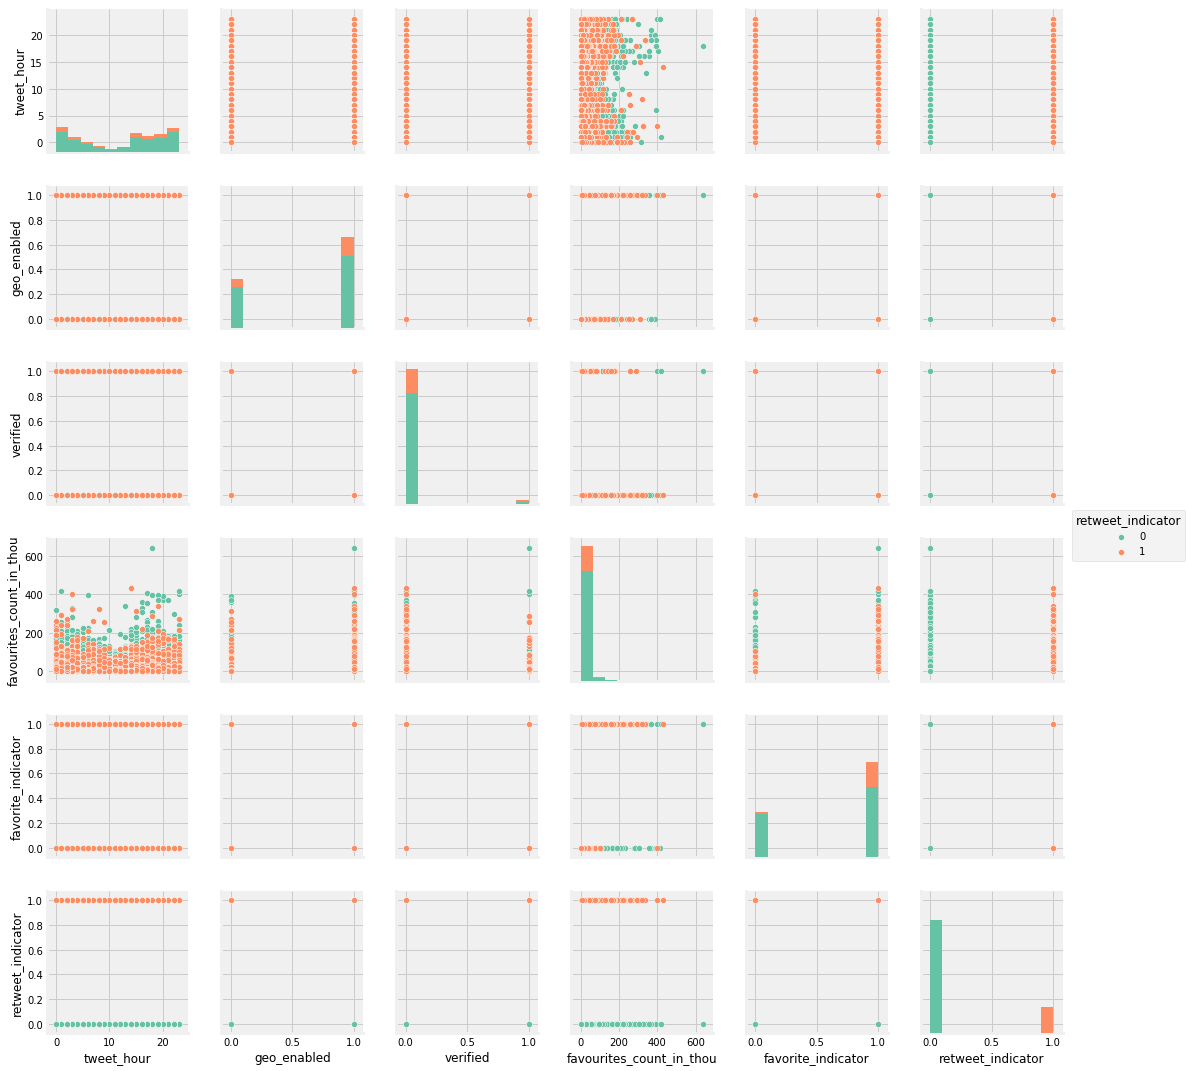

In [11]:
numeric_cols = ['tweet_hour',  'geo_enabled', 'verified', 'favourites_count_in_thou',\
                'favorite_indicator', 'retweet_indicator','listed_count_in_hund',\
                'followers_count_in_thou', 'friends_count_in_hund','statuses_count_in_thou']
sns.pairplot(data= df[numeric_cols[0:6]], hue = 'retweet_indicator', palette="Set2")

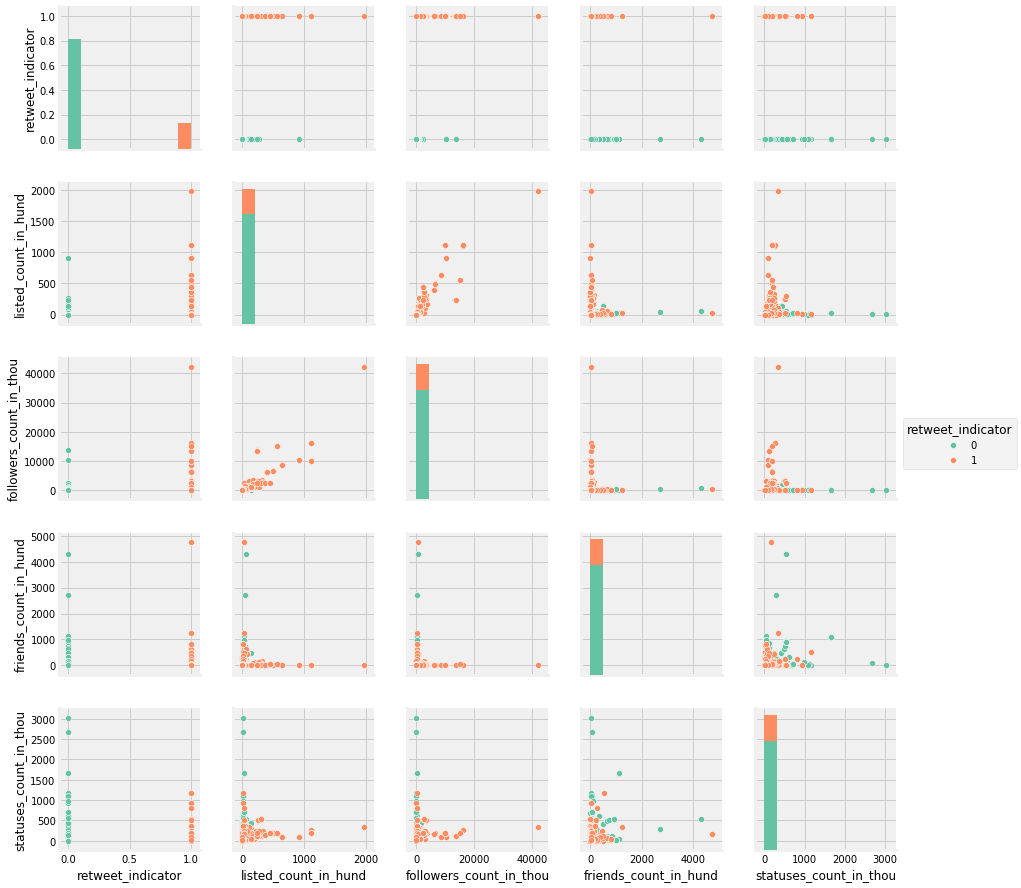

In [12]:
sns.pairplot(data= df[numeric_cols[5:]], hue = 'retweet_indicator', palette="Set2")

The below visualizations are the most useful to look at the relationship between retweet_indicator and the levels of the other categorical variables. Each bar represents 100% of tweets in each of the categories of a particular categorical variable. The proportion of each of these populations that were retweeted is shown in red. I was looking for categorical variables with differences in retweets across levels, as this would indicate importance in a variable in a model predicting retweet. 

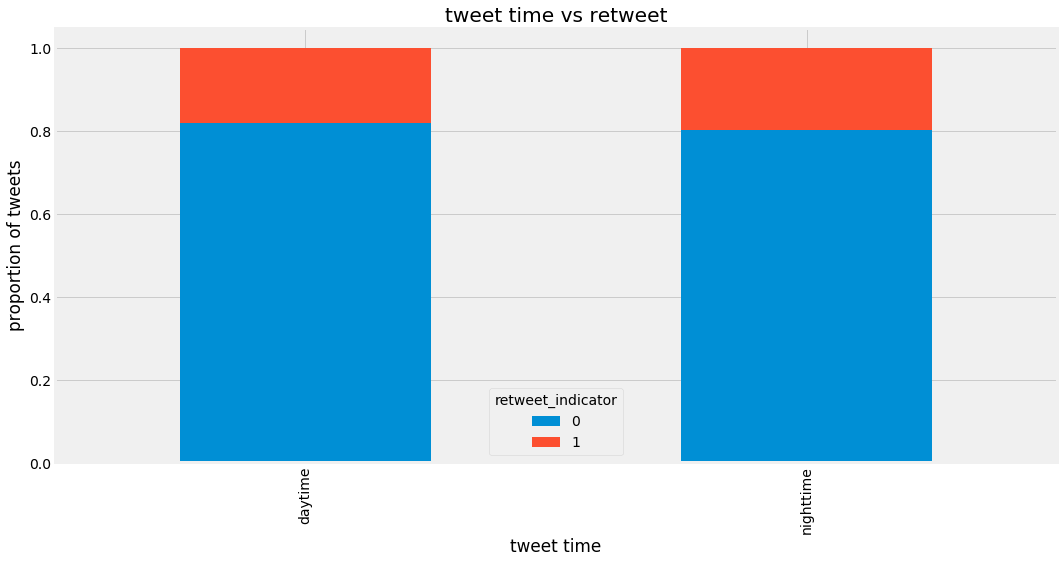

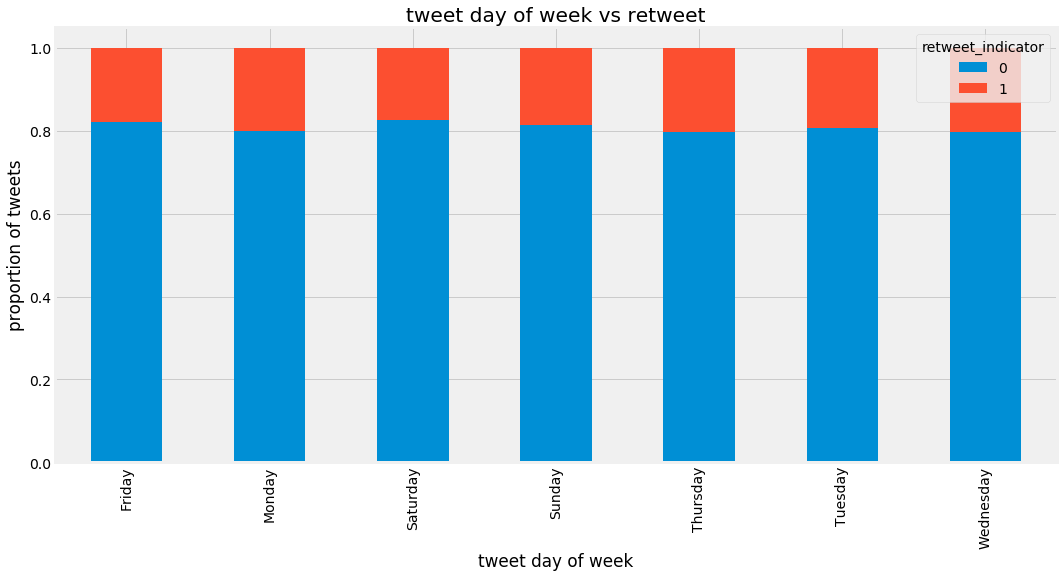

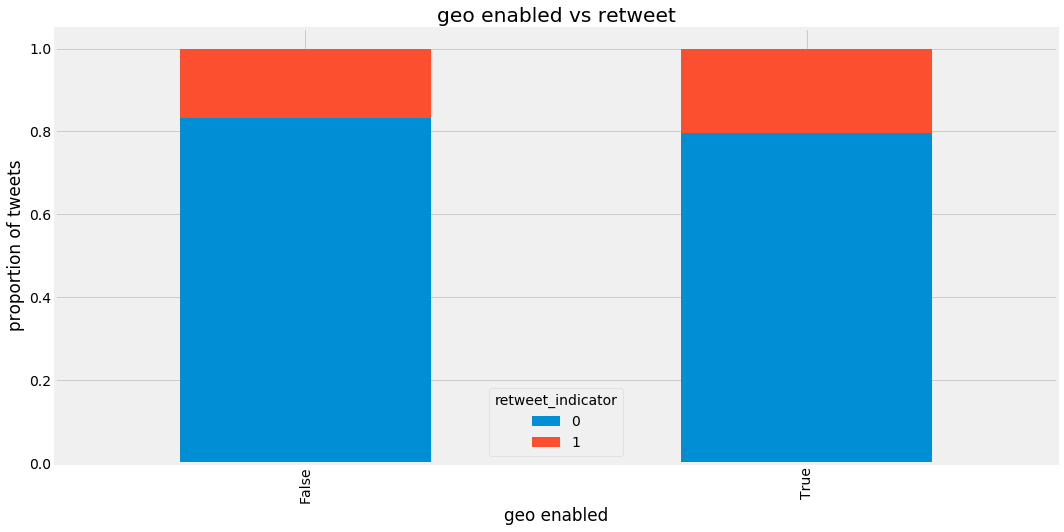

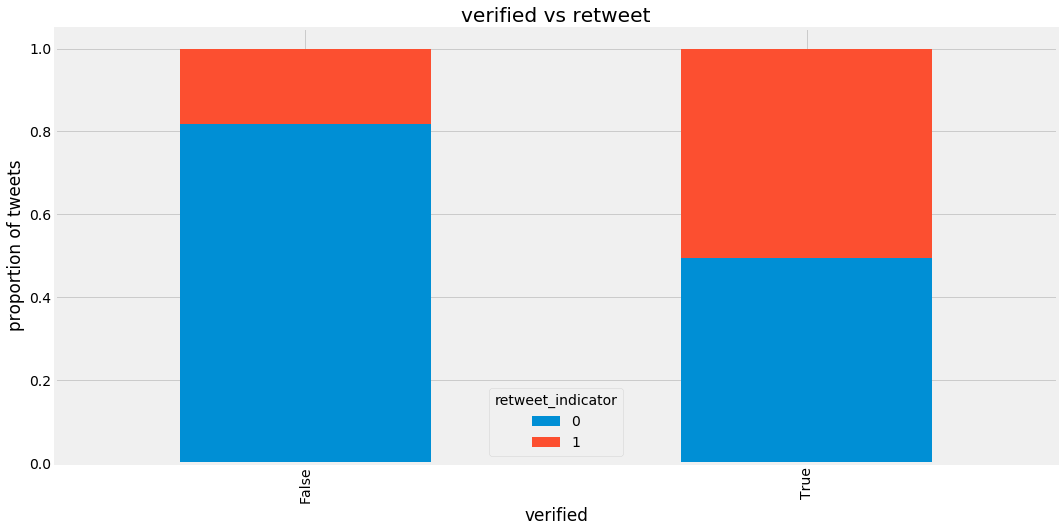

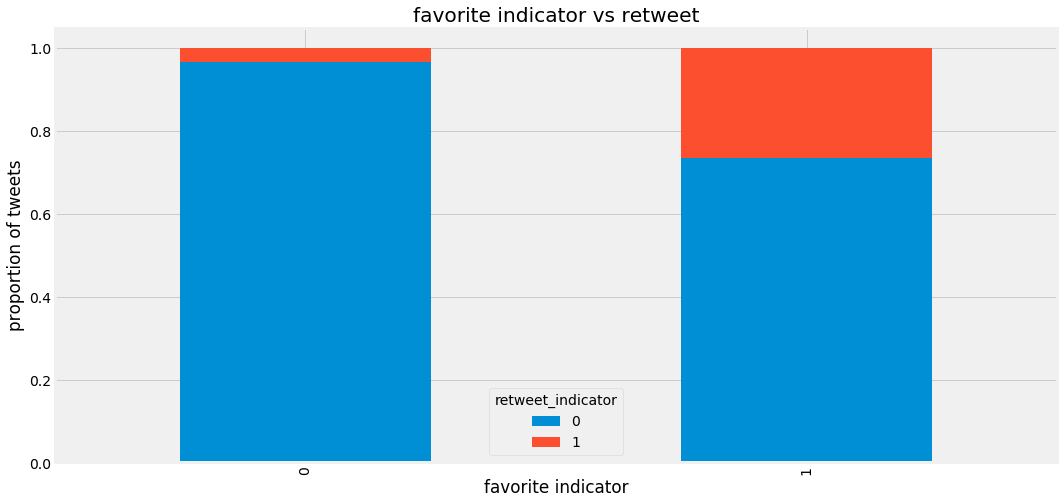

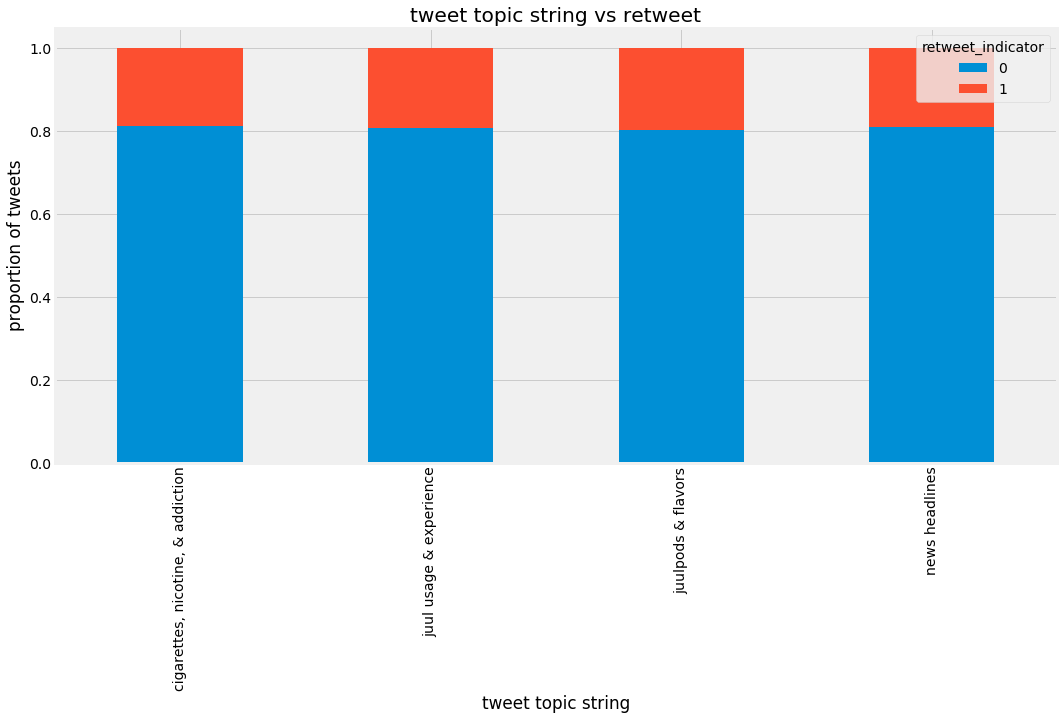

In [9]:
categorical_vars = ['tweet_time','tweet_day_of_week','geo_enabled',\
                   'verified','favorite_indicator','tweet_topic_string']

for c in categorical_vars:
    stacked_data = pd.crosstab(df[c], df['retweet_indicator'])
    stacked_data.div(stacked_data.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    c = re.sub(r'_',' ',c)
    plt.title(c + ' vs retweet')
    plt.xlabel(c)
    plt.ylabel('proportion of tweets')    plt.ylabel('proportion of tweets')

    #plt.savefig('salary_bar_chart')

There are some null values for the location and profile description columns

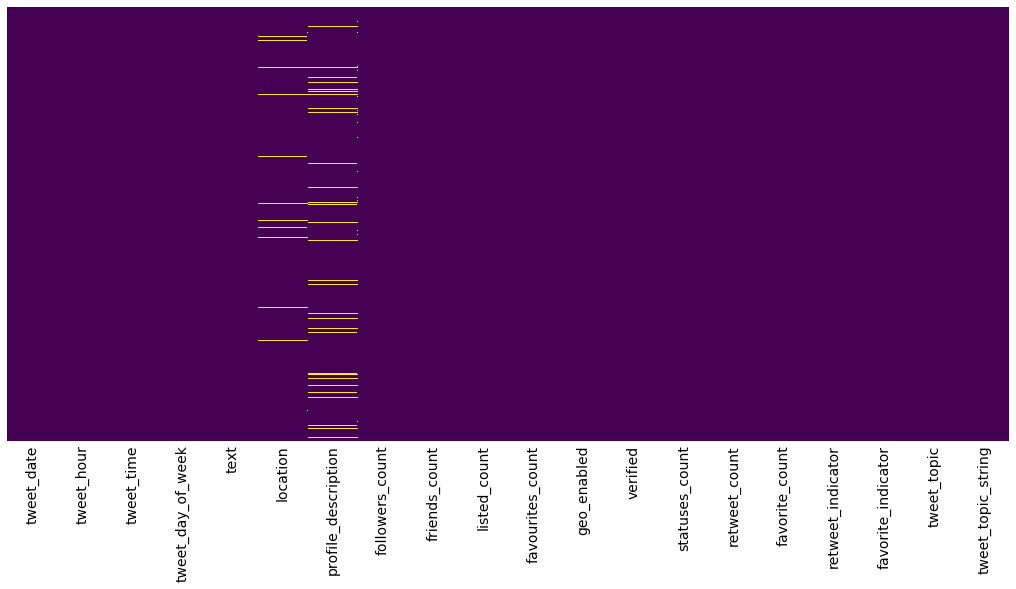

In [22]:
sns.heatmap(df.isnull(), yticklabels = False, cbar= False, cmap = 'viridis')

Visualize the distributions of some of the numeric variables.

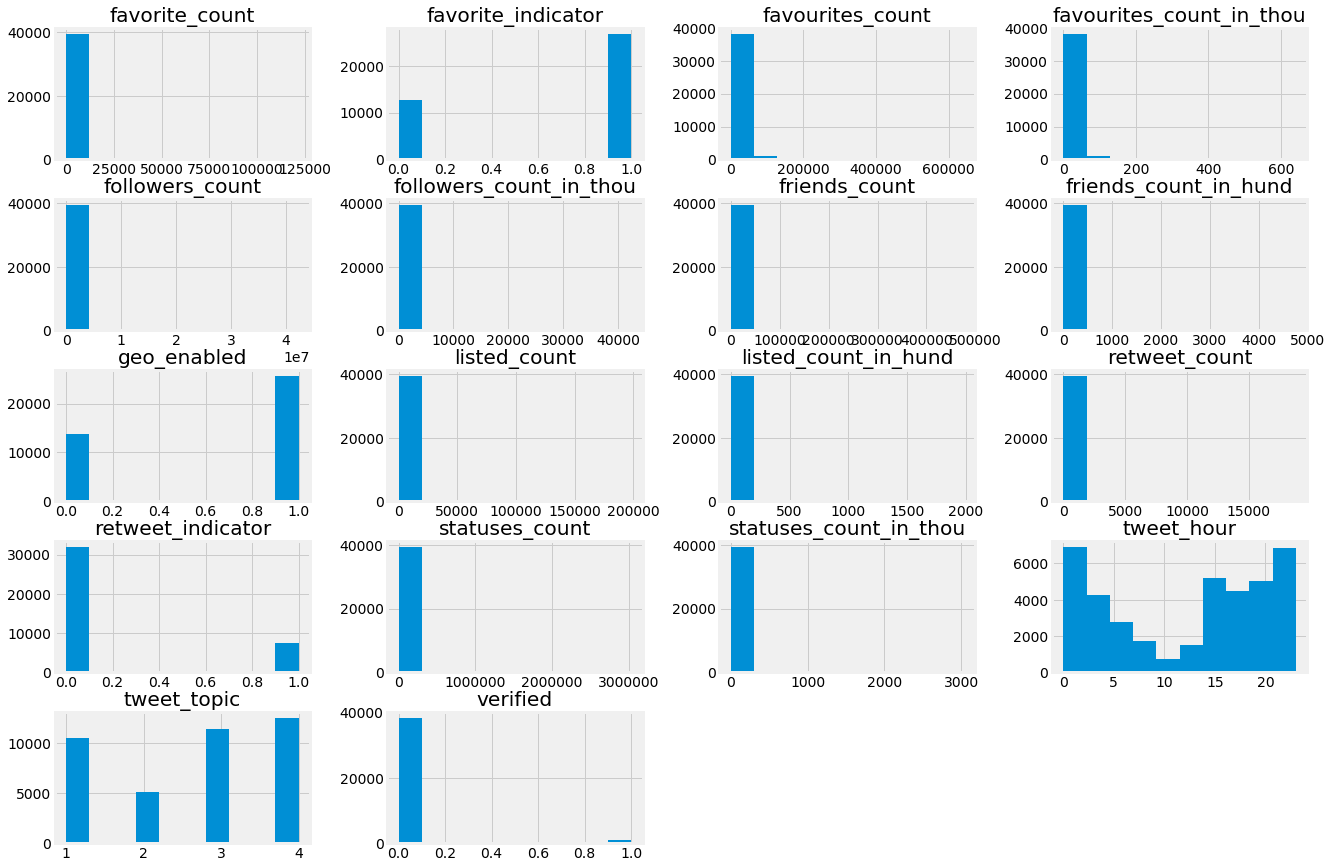

In [81]:
num_bins = 10
df.hist(bins=num_bins, figsize=(20,15))
plt.show()

Show the mean of numeric variables across each level of retweet indicator.  It sees that tweets with retweets tended to have more followers, friends and statuses than tweets which were not retweeted.

In [82]:
df.groupby('retweet_indicator').mean()

,tweet_hour,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,retweet_count,favorite_count,favorite_indicator,tweet_topic,friends_count_in_hund,listed_count_in_hund,followers_count_in_thou,favourites_count_in_thou,statuses_count_in_thou
retweet_indicator,,,,,,,,,,,,,,,,,
0,12.196314,3747.514197,740.009496,46.813996,13148.153378,0.639432,0.017676,18387.088128,0.000000,2.616303,0.616930,2.656105,7.400095,0.468140,3.747514,13.148153,18.387088
1,12.323444,99120.317086,1523.756954,743.311921,15131.265166,0.691656,0.076689,19750.310464,10.838808,63.502781,0.942914,2.647815,15.237570,7.433119,99.120317,15.131265,19.750310


Look at the same thing by topic and visualize using a heatmap. There seem to be differences in the values of some of the features across topics, but the value of retweet is virtually constant across all topics. Doesn't seem promising as a useful variable. Maybe it will be more useful in a multivariate model (a girl can dream).

In [77]:
df.groupby('tweet_topic_string').mean()

,tweet_hour,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,retweet_count,favorite_count,retweet_indicator,favorite_indicator,tweet_topic
tweet_topic_string,,,,,,,,,,,,,
"cigarettes, nicotine, & addiction",12.201121,8643.796876,871.301241,76.138166,14193.654465,0.665118,0.016660,15308.694674,2.898198,22.313336,0.186304,0.714698,4.0
juul usage & experience,11.822723,22132.944333,508.148444,59.648777,14528.232467,0.692073,0.011133,13679.073937,0.923875,8.617566,0.191265,0.751546,1.0
juulpods & flavors,11.992697,5381.417510,598.164980,58.606775,14617.512978,0.671623,0.015486,13833.962253,2.505323,14.684910,0.197888,0.713506,3.0
news headlines,13.596588,91441.724064,2373.036870,953.568543,7405.241028,0.473622,0.125907,47794.593057,1.464405,5.273387,0.189253,0.367523,2.0


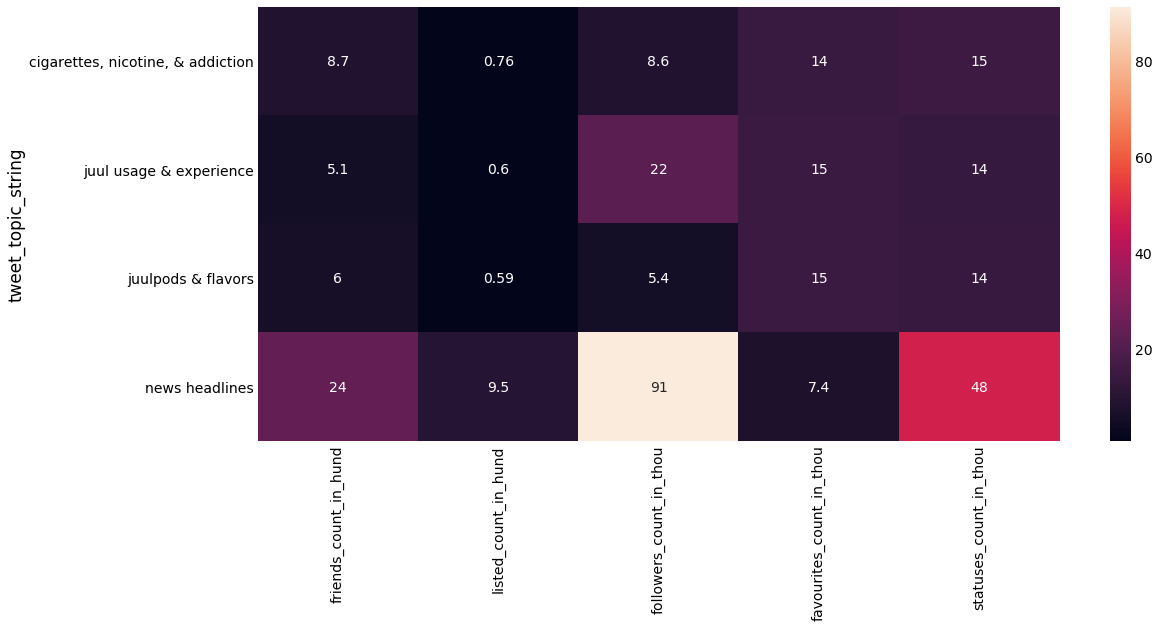

In [83]:
sns.heatmap(df[['friends_count_in_hund','listed_count_in_hund','followers_count_in_thou', 'favourites_count_in_thou',\
                'statuses_count_in_thou','tweet_topic_string']].groupby('tweet_topic_string').mean(),annot=True)

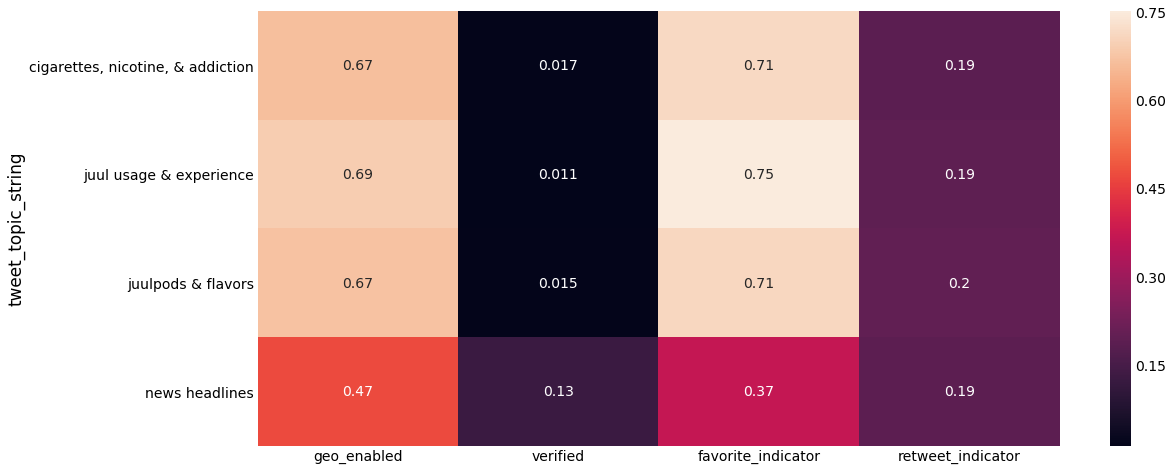

In [84]:
# uh oh... doesn't look like these topics differentiate retweeting
sns.heatmap(df[['geo_enabled', 'verified', 'favorite_indicator','retweet_indicator','tweet_topic_string']].groupby('tweet_topic_string').mean(), annot = True)

Look at the correlations across all numeric variables. Here, we want to focus on the correlation of each variable and 'retweet indicator' in addition to the correlations across the predictor variables. Verified has the strongest linear correlation with verified indicator, and followers count and listed count had the strongest linear correlation.

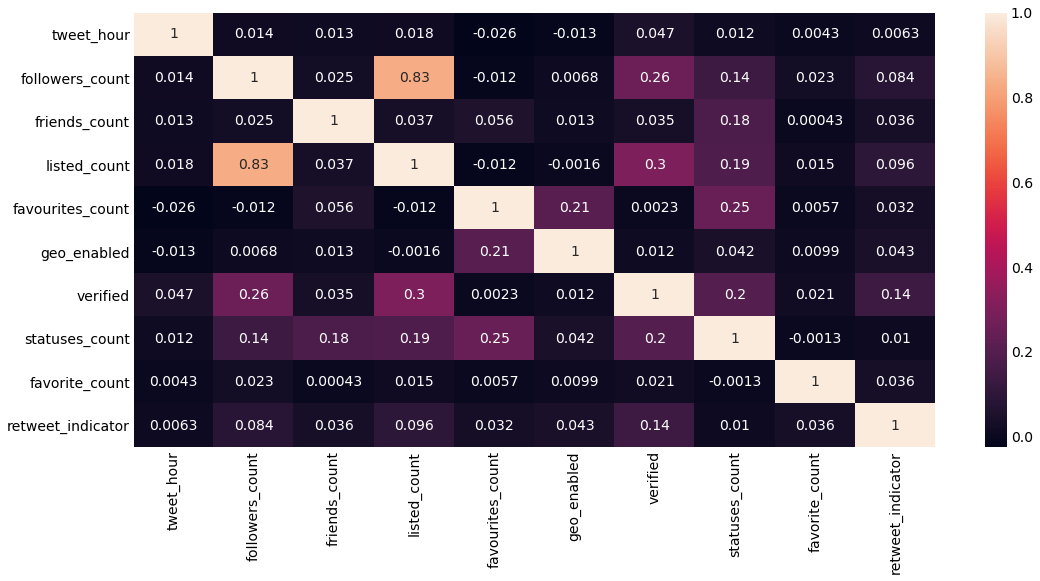

In [34]:
sns.heatmap(df[numeric_cols].corr(), annot= True)

## Feature Engineering

In order to leverage the actual text in each tweet, the text within the tweet was used to create topic models using Latent Dirichlet Allocation (LDA). After performing LDA on the entire dataset and cross validating the model which had the highest cohesion score to determine the appropriate number of topics, four topics were manually chosen based on the tweets with the highest topic proportions for those topic classifications. This dataset was then split into training and testing and then used to create a model to predict topic. Supporting information can be found here:
- supporting-code-and-data/3_create-topic-model-apply-to-corpus.ipynb
- LDA Model: supporting-code-and-data/juul_lda_topic_model.pickle
- Naive Bayes Model: supporting-code-and-data/juul_naive_bayes_topic_classifier.pickle (modeled using supporting-code-and-data/juul_topic_classification_filtered.csv dataset)

Some of the results are shown below.

In [55]:
topic_data = pd.read_csv('supporting-code-and-data/juul_topic_classification_filtered.csv')
topic_data['topic_string'] = np.where(topic_data['topic_numeric'] == 1,'juul usage & experience', topic_data['topic_string'])
topic_data['topic_string'] = np.where(topic_data['topic_numeric'] == 2,'news headlines', topic_data['topic_string'])
topic_data['topic_string'] = np.where(topic_data['topic_numeric'] == 3,'juulpods & flavors', topic_data['topic_string'])
topic_data['topic_string'] = np.where(topic_data['topic_numeric'] == 4,'cigarettes, nicotine, & addiction', topic_data['topic_string'])

In [56]:
#gather the ten observations which are most representative for each topic
topic_data_grp = topic_data[['text_string', 'Keywords', 'Topic_Perc_Contrib', 'topic_string']].groupby('topic_string')
top_topic_tweets = pd.DataFrame()
for group, value in topic_data_grp:
    top_topic_tweets = pd.concat([top_topic_tweets,
                        value.sort_values('Topic_Perc_Contrib', 
                        ascending = [0]).head(10)], axis=0)

See results for topic one below, along with the output from pyLDAvis. This shows the topics in a different space. This is useful to visualize the space between different topics and ensure topics are spaced out.

In [80]:
pd.set_option('display.max_colwidth', -1)
top = 'juul usage & experience'
topic_df = top_topic_tweets[top_topic_tweets.topic_string == top]
print(top)
print(topic_df.Keywords.unique())
display(topic_df[['text_string']])

juul usage & experience
[' hit bro let like said pod please pods cool one']


,text_string
0,yo bro got juul bro cmon bro real quick restroom bro let hit juul bro ill even pay like
1,@whouphitlike bro pls lemme hit juul pls need get nicced dude pls ill take bathroom get caught pls bro
2,@leopinkyoshi bro take hit juul bro bro please need hit bro come dude need morning b
3,parents fucking champions threw entire temper tantrum made help look juul car
4,mom took juul rn said thank _ _ next gt _ _
5,@slixkbaxk bro gon lie one juul innat bitch even use bathroom g move around
6,straight juul shit expensive habit thought shit dead ion even want pods
7,grandpa hit juul one hit man please please dude one hit
8,bro let take hit juul bro one hit bro please bro
9,barbara made #switchtojuul hear adult smokers made switch join #juul community


<left>![Topic 1](supporting-code-and-data/topic_1-juul_use.PNG "Title")<left>

In [81]:
pd.set_option('display.max_colwidth', -1)
top = 'news headlines'
topic_df = top_topic_tweets[top_topic_tweets.topic_string == top]
print(top)
print(topic_df.Keywords.unique())
display(topic_df[['text_string']])

news headlines
[' stop flavors flavored stores ecigarette fda vaping nicotine selling sales']


,text_string
500,check post us news vibe juul halts flavored ecig retail sales removes social media presence
501,mainstream media like @cnbc @wsj reporting #juul getting ready pull flavored vapes store shelves
502,juul suspends sales flavored products stops social media address underage vaping via @time #csulbsoc
503,fox business juul stops sale flavored ecigarettes stores halts social media presence via @googlenews
504,fda majorly restricting sale flavored juul pods fight teen vaping via @mashable thank god
505,@nytimes reports breaking news @juulvapor #ecig company stop sales flavors stores hault
506,juul stop selling ecigarette flavors stores halt social media promotions via @nytimes great mov
507,juul stop selling ecigarette flavors stores halt social media promotions check via nyt
508,shared via nyt juul stop selling ecigarette flavors stores halt social media promotions
509,juul cuts flavored nicotine supply stores shutters social media verge attack vaping p


<left>![Topic 2](supporting-code-and-data/topic_2-news_headlines.PNG "Title")<left>

In [82]:
pd.set_option('display.max_colwidth', -1)
top = 'juulpods & flavors'
topic_df = top_topic_tweets[top_topic_tweets.topic_string == top]
print(top)
print(topic_df.Keywords.unique())
display(topic_df[['text_string']])

juulpods & flavors
[' pods mango buy got pod banned like get flavored mint']


,text_string
1000,@hungrybaroni @mlghuckins @fanaticthedon juul pods school shootings gun control yall place lmfaoooo
1002,start selling weed infused juul pods called buul pods ie boolin boys
1001,got flavored juul pods banned assault rifles lmao aint crazy shit think
1003,us really made harder buy flavored juul pods buy assault rifle
1004,wait theyre banning flavored juul pods theyre banning flavored cigars wtf
1005,flavored juul pods got banned literally got juul control got gun control
1006,flavored juul pods get banned anyone dies weve many people die gunrelat
1007,@indigcababy get mango juul pod go buy semi automatic rifle life gr8
1008,got juul thursday n already asking mom buy pods leak texts
1009,ok sorry banning juul pods important gun control good fucking god


<left>![Topic 3](supporting-code-and-data/topic_3-juulpods_flavors.PNG "Title")<left>

In my opinion, this is the weakest topic in terms of differentiation from the others, but it did capture a different topic, so I kept it as a topic

In [83]:
pd.set_option('display.max_colwidth', -1)
top = 'cigarettes, nicotine, & addiction'
topic_df = top_topic_tweets[top_topic_tweets.topic_string == top]
print(top)
print(topic_df.Keywords.unique())
display(topic_df[['text_string']])

cigarettes, nicotine, & addiction
[' like pod get smoking cigarettes people charger nicotine pods quit']


,text_string
1500,yes know juul pod much nicotine pack cigs yes go least one pod day fuck
1501,new #patent lawsuit juul labs inc v shenzhen ovns technology co ltd et al ilnd
1502,new #patent lawsuit juul labs inc v shenzhen haka flavor technology co ltd et al ded
1503,luring drunk friends home __ gt juul want __ juul lt get fuck
1504,get ah juuul noah looses juul noah gets juul juul goes mia get point
1505,smoking juul last days cig rn hearts moving fast think hate feeling
1506,juul pods contain cigarettes nicotine per pod actually around cigarettes per pod grante
1507,@jamestein7 lol buy juul pods remember one juul pod contains much nicotine twenty cigarettes
1509,huff puff keep away stuff one juul pod contains cigarettes worth nicotine
1508,remember ed twit like everyone smoked cigarettes curve appetite hit juul lmfao


<left>![Topic 2](supporting-code-and-data/topic_4-cigarettes_nicotine_addiction.PNG "Title")<left>

Let's look a little more closely at location. Ideally, I would want to attach census data to the lat/long coordinates to glean insight on demographics, but this field was extremely sparse throughout the data. Because of this, I had to rely heavily on self-reported location data.

In [210]:
location_df = df[['location','tweet_topic_string']]
location_df['n'] = 1
location_df.head()
grp = location_df.groupby(['location','tweet_topic_string']).sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [260]:
undone = grp.unstack()
undone = undone[undone > 15].dropna(axis=0, how='any')

for i in range(0,4):
    print(undone.columns[i])
    print(undone.iloc[:,i].sort_values(ascending = False)[1:15])
    print('\n')


('n', 'cigarettes, nicotine, & addiction')
location
New York, NY        218.0
Chicago, IL         206.0
Los Angeles, CA     179.0
Texas, USA          129.0
California, USA     128.0
Brooklyn, NY        122.0
New York, USA       103.0
Houston, TX         102.0
Florida, USA        94.0 
Dallas, TX          87.0 
Austin, TX          84.0 
Boston, MA          80.0 
Philadelphia, PA    76.0 
Seattle, WA         69.0 
Name: (n, cigarettes, nicotine, & addiction), dtype: float64


('n', 'juul usage & experience')
location
Chicago, IL        203.0
New York, NY       158.0
Los Angeles, CA    156.0
Houston, TX        122.0
California, USA    98.0 
Texas, USA         95.0 
Brooklyn, NY       88.0 
Florida, USA       79.0 
New York, USA      79.0 
Ohio, USA          71.0 
Dallas, TX         69.0 
Seattle, WA        64.0 
Austin, TX         63.0 
Boston, MA         61.0 
Name: (n, juul usage & experience), dtype: float64


('n', 'juulpods & flavors')
location
Los Angeles, CA    190.0
New York, NY  

When plotting a stacked bar chart by location and topic, you can see the distribution of tweet topic by self-reported topic. From this, you can see cities (NYC, DC, San Fransisco etc) have larger proportions of news related JUUL tweets.

Text(0,0.5,'Number of Tweets')

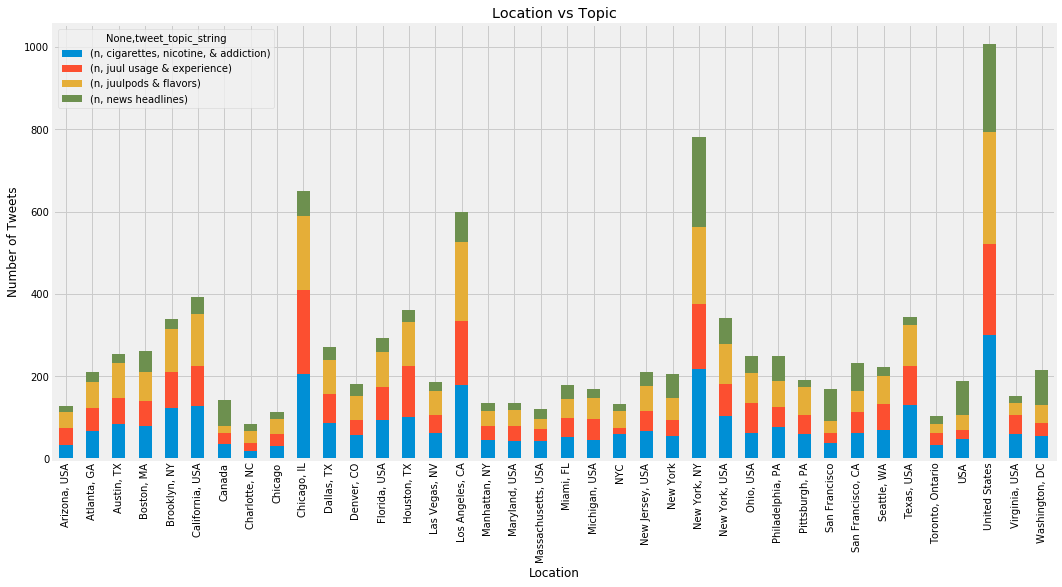

In [261]:
undone.plot(kind='bar', stacked=True)
plt.title('Location vs Topic')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')

## Data Preprocessing

Create dummy variables for categorical features.

In [160]:
# create dummy dfs
tweet_time = pd.get_dummies(df['tweet_time'], drop_first = True)
tweet_day_of_week = pd.get_dummies(df['tweet_day_of_week'], drop_first = True)
tweet_topic_string = pd.get_dummies(df['tweet_topic_string'], drop_first = True)

In [161]:
df_modeling = df[['geo_enabled', 'verified', 'favorite_indicator', 
                  'friends_count_in_hund', 'listed_count_in_hund',
                  'followers_count_in_thou', 'favourites_count_in_thou',
                  'statuses_count_in_thou']]

In [162]:
# change to 0/1 values
df_modeling = df_modeling.applymap(lambda x: 1 if x == True else x)
df_modeling = df_modeling.applymap(lambda x: 0 if x == False else x)

In [163]:
# combine dataset and create modeling dataframe
df_modeling = pd.concat([df_modeling, tweet_time, tweet_day_of_week,tweet_topic_string], axis = 1)

df_modeling.head()

,geo_enabled,verified,favorite_indicator,friends_count_in_hund,listed_count_in_hund,followers_count_in_thou,favourites_count_in_thou,statuses_count_in_thou,nighttime,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,juul usage & experience,juulpods & flavors,news headlines
0,0,0,1,11.47,0.01,0.088,0.567,0.406,1,0,1,0,0,0,0,0,1,0
1,0,0,1,11.47,0.01,0.088,0.567,0.406,1,0,0,0,0,1,0,0,0,1
2,0,0,0,11.47,0.01,0.088,0.567,0.406,1,1,0,0,0,0,0,1,0,0
3,0,0,0,0.12,0.00,0.016,0.006,0.029,1,1,0,0,0,0,0,0,0,1
4,0,1,1,3.73,0.40,19.574,0.668,6.994,1,1,0,0,0,0,0,0,0,0


Scale data and separate into X and Y matrices before 

In [164]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_modeling)
y = df['retweet_indicator']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,#df_modeling, 
                                                    y, #df['retweet_indicator'],
                                                    test_size = .3,
                                                    random_state = 42)

In [166]:
y_train.mean() # baseline retweet percentage

0.19065894279507603

## Machine Learning

Fit three different models - Logistic Regression, Random Forest, and SVM. Use gridsearch to fit each model and select best fit.

In [185]:
# import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
grid_values = {'penalty': ['l1','l2'], 
               'class_weight': [{0:0.8, 1:0.2},{0:0.85, 1:0.15},'balanced'],
               'C': [0.01,0.1,1,10,100]}
#instantiate
logReg = LogisticRegression(random_state = 42)

#fit the grid
cvLogReg = GridSearchCV(logReg, grid_values, cv=5, verbose=1)
#cvLogReg.fit(X_train, y_train)
best_logreg_model = cvLogReg.fit(X_train, y_train)
cvLogReg_pred = best_logreg_model.predict(X_test)

# print best hyperparameters
print('Best Penalty:', best_logreg_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_logreg_model.best_estimator_.get_params()['C'])
print('Best Class Weight:', best_logreg_model.best_estimator_.get_params()['class_weight'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Penalty: l2
Best C: 0.01
Best C: {0: 0.8, 1: 0.2}


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   18.5s finished


In [300]:
filename = 'juul_lrc_retweet_model.pickle'
pickle.dump(best_logreg_model, open(filename,'wb'))

In [267]:
# import
from sklearn.svm import SVC
grid_values = {'class_weight': [{0:0.8, 1:0.2},'balanced'],
               'C': [0.01,0.1,1,10]}
#instantiate
svc = SVC(random_state = 42)
#fit the grid
cvSVC = GridSearchCV(svc, grid_values, cv=5, verbose=1)
best_svc_model = cvSVC.fit(X_train, y_train)
cvSVC_pred = best_svc_model.predict(X_test)

# print best hyperparameters
print('Best C:', best_svc_model.best_estimator_.get_params()['C'])
print('Best Class Weight:', best_svc_model.best_estimator_.get_params()['class_weight'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 31.8min finished


Best C: 10
Best Class Weight: {0: 0.8, 1: 0.2}


In [271]:
svc = SVC(class_weight= {0:0.8, 1:0.2},C = 10, probability=True, random_state = 42)
#fit the grid
best_svc_model = svc.fit(X_train, y_train)
cvSVC_pred = best_svc_model.predict(X_test)

In [298]:
filename = 'juul_svc_retweet_model.pickle'
pickle.dump(best_svc_model, open(filename,'wb'))

In [266]:
from sklearn.ensemble import RandomForestClassifier
grid_values = {'criterion': ['entropy','gini'], #'gini',
               'max_depth': list(range(2,8,2)),
               'min_samples_leaf': list(range(10,30,5)),
               'class_weight': [{0:0.8, 1:0.2},'balanced_subsample']}
#instantiate
randForest = RandomForestClassifier(random_state = 42)

#fit the grid
cvRandFor = GridSearchCV(randForest, grid_values, cv=5, verbose=1)
best_randfor_model = cvRandFor.fit(X_train, y_train)
cvRandFor_pred = best_randfor_model.predict(X_test)

# print best hyperparameters
print('Best Criterion:', best_randfor_model.best_estimator_.get_params()['criterion'])
print('Best Max Depth:', best_randfor_model.best_estimator_.get_params()['max_depth'])
print('Best Min Samples Leaf:', best_randfor_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best Class Weight:', best_randfor_model.best_estimator_.get_params()['class_weight'])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


Best Criterion: gini
Best Max Depth: 6
Best Min Samples Leaf: 15
Best Class Weight: {0: 0.8, 1: 0.2}


In [299]:
filename = 'juul_rfc_retweet_model.pickle'
pickle.dump(best_randfor_model, open(filename,'wb'))

## Evaluation
Create a function to evaluate each classification model.  Plot the ROC which measures segmentation, the classification report which shows precision (of predicted positive, how much were true positive) and recall (of actually positive, how many true positive), and the confusion matrix.

In [277]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score #Area under the curve
from sklearn.metrics import roc_curve #Receiver Operator Curve

def performance(y_test, y_pred, model, X_test):
    log_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    #let's plot it!
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % log_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    #make it pretty!
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [334]:
def plot_importance(feature_importances, model_name):
    n_groups = len(feature_importances)
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.7
    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rfc_plot = plt.barh(index, feature_importances.importance.values, bar_width,
                     alpha=opacity,
                     color='b',
                     label=model_name)


    plt.xlabel('Importance Measure')
    plt.ylabel('Predictor')
    plt.title('Variable Importance')
    plt.yticks(index + bar_width / 2, feature_importances.index.values)
    plt.legend()

    plt.tight_layout()
    plt.show()

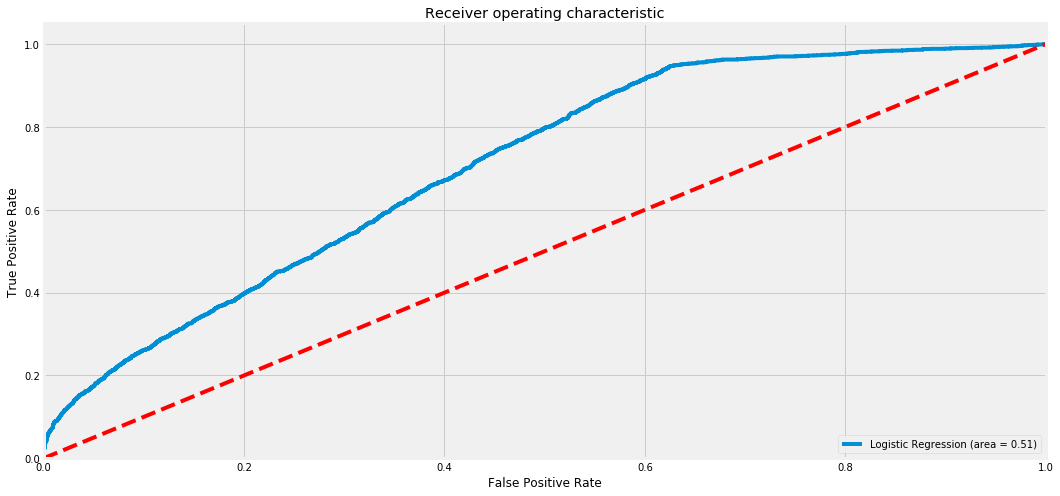

             precision    recall  f1-score   support

          0       0.81      1.00      0.89      9554
          1       0.96      0.01      0.02      2284

avg / total       0.84      0.81      0.73     11838

[[9553    1]
 [2259   25]]


0.5054205205400806

In [278]:
plot_roc(y_test, cvLogReg_pred, best_logreg_model, X_test)
print(classification_report(y_test, cvLogReg_pred))
print(confusion_matrix(y_test, cvLogReg_pred))
roc_auc_score(y_test, cvLogReg_pred)

Show importance of each variable in both the linear regression model and the random forest model. For the logistic regression classifier, use coefficient estimates for this.

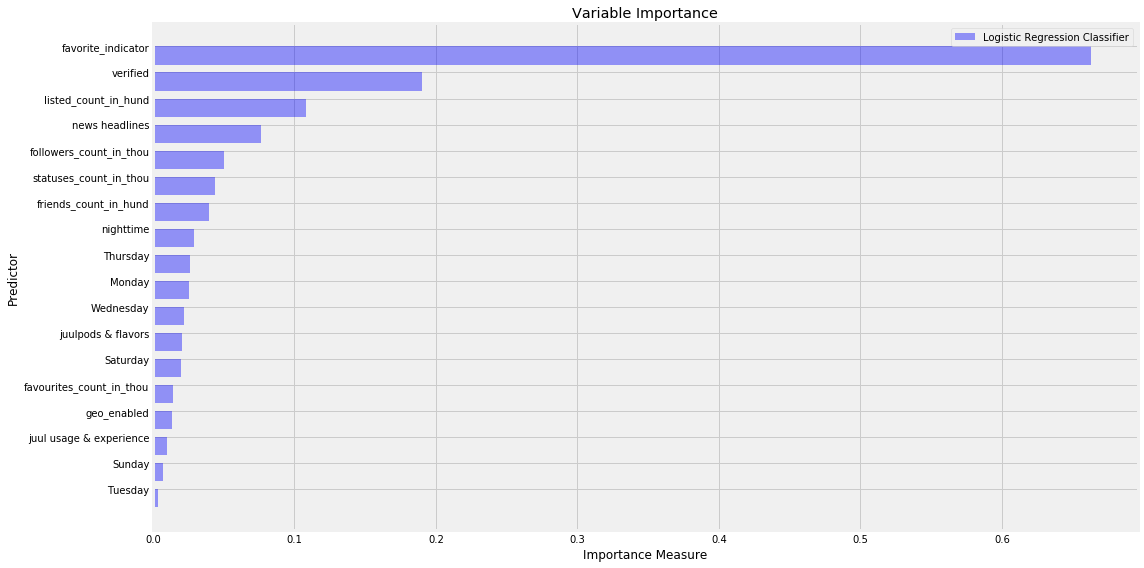

[('geo_enabled', array([0.01380411])), ('verified', array([0.18988528])), ('favorite_indicator', array([0.66281093])), ('friends_count_in_hund', array([0.03949464])), ('listed_count_in_hund', array([0.10812541])), ('followers_count_in_thou', array([0.04996397])), ('favourites_count_in_thou', array([0.01405224])), ('statuses_count_in_thou', array([-0.04381784])), ('nighttime', array([0.0289068])), ('Monday', array([0.02579676])), ('Saturday', array([-0.01951724])), ('Sunday', array([0.00714269])), ('Thursday', array([0.02616286])), ('Tuesday', array([-0.00341097])), ('Wednesday', array([0.02163593])), ('juul usage & experience', array([-0.00978418])), ('juulpods & flavors', array([0.02025643])), ('news headlines', array([0.07609174]))]


In [347]:
log_coeffs = best_logreg_model.best_estimator_.coef_.reshape(18,1)
feature_importances = pd.DataFrame(abs(log_coeffs),
                                   index = df_modeling.columns,
columns=['importance']).sort_values('importance', ascending=True)
plot_importance(feature_importances, 'Logistic Regression Classifier')
print(list(zip(df_modeling.columns, log_coeffs)))

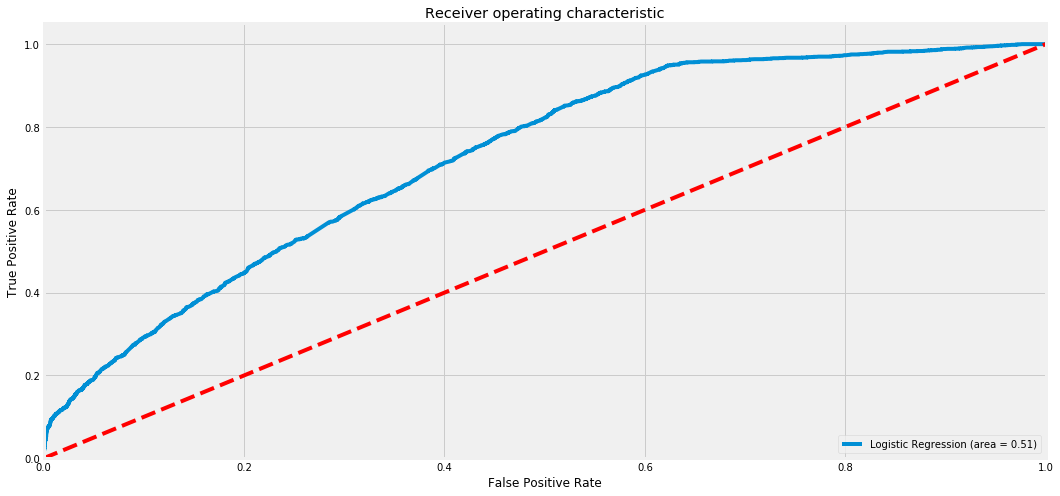

             precision    recall  f1-score   support

          0       0.81      1.00      0.89      9554
          1       0.87      0.02      0.04      2284

avg / total       0.82      0.81      0.73     11838

[[9547    7]
 [2236   48]]


0.510141542204382

In [282]:
plot_roc(y_test, cvRandFor_pred, best_randfor_model, X_test)
print(classification_report(y_test, cvRandFor_pred))
print(confusion_matrix(y_test, cvRandFor_pred))
roc_auc_score(y_test, cvRandFor_pred)

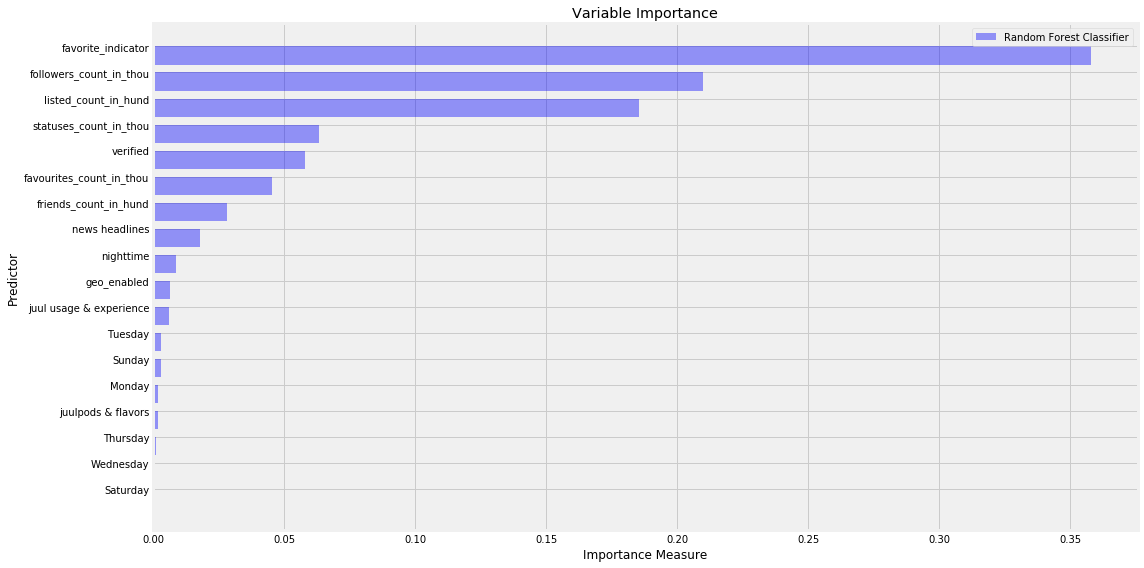

In [348]:
forest = best_randfor_model.best_estimator_
importances = forest.feature_importances_
feature_importances = pd.DataFrame(importances,
                                   index = df_modeling.columns,
columns=['importance']).sort_values('importance', ascending=True)
plot_importance(feature_importances, 'Random Forest Classifier')

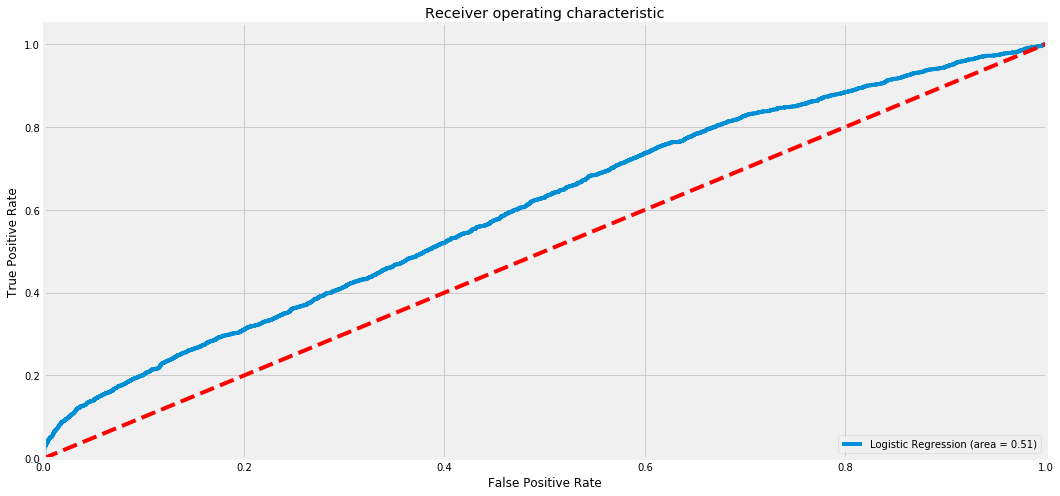

             precision    recall  f1-score   support

          0       0.81      1.00      0.90      9554
          1       0.88      0.03      0.05      2284

avg / total       0.82      0.81      0.73     11838

[[9546    8]
 [2225   59]]


0.5124972641455134

In [283]:
plot_roc(y_test, cvSVC_pred, best_svc_model, X_test)
print(classification_report(y_test, cvSVC_pred))
print(confusion_matrix(y_test, cvSVC_pred))
roc_auc_score(y_test, cvSVC_pred)

In [355]:
## cannot get coefficients for linear estimator, need to do a PDP or something
best_svc_model.score(X_test, y_test)

0.8113701638790336

## Conclusion
- Whether a tweet was favorited, the number of followers and connectivity in the Twitter network is more predictive than the topics from tweet text
- The News Headline topic is the most predictive of retweet out of all four, but some actual news organizations are in the data, so this may be a contributor to its importance
- Juul usage & experience is much less important than other variables in the model

## Next Steps
- Collect more data to obtain less overlapping topics
- Experiment with removing hashtags before tokenizing
- Attempt to use other algorithms for building retweet model (XGBoost, Naïve Bayes) topic predictor (CNN)